In [ ]:
# Refactoring tips : https://pytorch.org/tutorials/beginner/nn_tutorial.html
# Module forward hook : https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/
# Module, Sequential, and organizing better : https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md
# writing your own optimizer http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html
# torch tensor quick start operatiosn https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/

In [2]:
import os
import torch
from torch import nn
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

# Dataset

In [12]:
class XORDataset(Dataset):
    """XOR dataset."""

    def __init__(self, num_samples = 200):
        """
        Args:
            num_samples: number of samples to generate
        """

        self.num_samples = num_samples
        self.X = np.random.randint(0,high=2, size=num_samples*2).reshape((num_samples, 2)).astype(np.float32)
        self.y = np.logical_xor(self.X[:,0], self.X[:,1]).reshape((num_samples,1)).astype(np.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #sample = {'X': self.X[idx], 'y': self.y[idx]}
        sample = (self.X[idx], self.y[idx])

        return sample

# Dataloaders, get_data

In [3]:
def get_data(batch_size):

    datasets = {
        'train' : XORDataset(200),
        'valid' : XORDataset(50),
    }
    loaders = {
    'train' : torch.utils.data.DataLoader(datasets['train'],  
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    'valid' : torch.utils.data.DataLoader(datasets['valid'], 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
    }
    return datasets, loaders
    

# Net model
## class XORnet

In [27]:
class XORnet(nn.Module):

    def __init__(self):
        super(XORnet, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.layers = nn.Sequential(
            self.linear, 
            self.Sigmoid, 
            self.linear2
        )
        # custom weight initialization
        nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
        for layer in nnLinearLayers:
            nn.init.normal_(layer.weight)

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

In [4]:
class learner():

    def __init__(self, model, lr, opt_name, loss_fn=nn.MSELoss()):
        self.model = model
        self.lr = lr
        self.loss_fn = loss_fn
        optimizers = {
            'adam': torch.optim.Adam(model.parameters(), lr = lr) ,
            'SGD': torch.optim.SGD(self.model.parameters(), lr = lr)
        }
        self.opt = optimizers[opt_name]

    def get_model(self):
        return self.model, self.opt, self.loss_fn

In [31]:
# to do : determine learning rate by grid search
'''To make comparisons easier, we use the
same learning rate η for FF+FB and FF, determined by grid search. 
We average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of
epochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest
number of epochs of the two networks that reached 100% training accuracy in 10 runs.'''

'To make comparisons easier, we use the\nsame learning rate η for FF+FB and FF, determined by grid search. \nWe average 10 runs, taking g = 0.7 and η = 0.025 for both networks. The number of\nepochs is capped to 300 epochs. With these constraints, η is optimized (by grid search) for the smallest\nnumber of epochs of the two networks that reached 100% training accuracy in 10 runs.'

# class statsLogger

In [5]:
class statsLogger():
    def __init__(self):
        self.accuracies=[]   # accuracy for each epoch
        self.losses=[]

    def startEpoch(self):
        self.epoch_total_samples=0
        self.epoch_correct_samples=0
        self.minibatch_losses=[]  # losses for all minibatches in the epoch

    def getMinibatchStats(self, pred, yb, loss, pref_fn=lambda pred : (pred>0.5).float() ):
        #Accuracy
        predicted = pref_fn(pred)
        minibatch_num_corrects = (predicted == yb).float().sum()
        minibatch_total = pred.shape[0]
        minibatch_accuracy = minibatch_num_corrects.item()/pred.shape[0]
        self.epoch_total_samples += minibatch_total
        self.epoch_correct_samples += minibatch_num_corrects.item()
        self.minibatch_losses.append(loss.item())

    def endEpoch(self):
        self.losses.append(np.array(self.minibatch_losses).mean())
        self.accuracies.append(100 * self.epoch_correct_samples / self.epoch_total_samples)
        
    

In [6]:
def fit(model, optimizer, loaders, epochs):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for xb, yb in loaders['train']:

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }


In [7]:
def plotTraining(loggers: list, learner: learner):
    
    fig, axs= plt.subplots(1, 2, figsize=(18, 6))  
    plt.title('XOR Dataset Opt={}, lr={}, loss_fn={}'
        .format(learner.opt.__class__.__name__, learner.lr, learner.loss_fn.__class__.__name__))

    axs[0].plot(loggers['train'].losses, label='Train loss')
    axs[0].plot(loggers['valid'].losses, label='Valid loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')

    axs[1].plot(loggers['train'].accuracies, label='Train accuracy')
    axs[1].plot(loggers['valid'].accuracies, label='Valid accuracy')
    axs[1].set_title('Accuracies')  
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('loss')

    plt.legend()
    plt.show()

# TRAINING !!! 

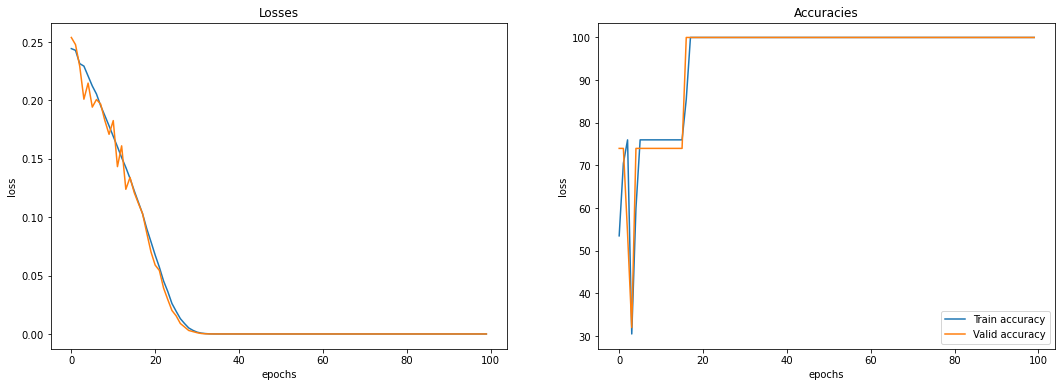

In [64]:
lr = 0.03
bs = 40
datasets, loaders = get_data(bs)
Xorln = learner(XORnet(), lr, 'adam')
model, opt, loss_fn = Xorln.get_model()

epochs=100
loggers = fit(model, opt, loaders, epochs)
plotTraining(loggers, Xorln)

In [69]:
# The Forward Hook for Visualising Activations 

visualisation = {}

inp = torch.randn(1,2)

def hook_fn(m, i, o):
  visualisation[m] = o 
  
net = model

print(model)
print('----------------------------------------')

for name, layer in net._modules.items():
    print('Name:', name)
    print('Layer:', layer)
    print('net._modules.items().__class__.__name__:', net._modules.items())
    layer.register_forward_hook(hook_fn)
  
out = net(inp) 

XORnet(
  (linear): Linear(in_features=2, out_features=2, bias=True)
  (Sigmoid): Sigmoid()
  (linear2): Linear(in_features=2, out_features=1, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)
----------------------------------------


AttributeError: 'odict_items' object has no attribute 'layers'

In [74]:
for layer in model.layers:
    print(layer)
    for a in layer.get_parameter(target=):
        print(a)

Linear(in_features=2, out_features=2, bias=True)


TypeError: get_parameter() missing 1 required positional argument: 'target'

In [39]:
from collections import OrderedDict
class XORnet2(nn.Module):

    def __init__(self):
        super(XORnet2, self).__init__()

        self.layers = nn.Sequential(
            OrderedDict([
                  ('fc1', nn.Linear(2, 2)),
                  ('sig1', nn.Sigmoid()),
                  ('fc2', nn.Linear(2, 1)),
                  ('sig2', nn.Sigmoid())
                  ])
        )

        # custom weight initialization
        nnLinearLayers = [layer for layer in self.layers if type(layer) == nn.Linear]
        for layer in nnLinearLayers:
            nn.init.normal_(layer.weight)
            # layer.register_forward_hook(self.hook_fn)

        #self.vis={}

    def forward(self, x):
        '''Forward pass'''
        x = self.layers(x)
        #self.trace.append(x)
        return x

class XORnet3(nn.Module):

    def __init__(self):
        super(XORnet3, self).__init__()

        self.fc1=nn.Linear(2, 2)
        self.sig1=nn.Sigmoid()
        self.fc2=nn.Linear(2, 1)
        self.sig2=nn.Sigmoid()
        
        self.activations=[0 for i in range(3)] # 3 "layers" : input/hidden/output

        # custom weight initialization

        for layer in [self.fc1, self.fc2]:
            nn.init.normal_(layer.weight)


    def forward(self, x):
        '''Forward pass'''
        
        x2 = self.fc1(x)
        x2 = self.sig1(x2)
        x3 = self.fc2(x2)
        x3 = self.sig2(x3)
        self.store_activations(x, x2, x3)
        return x3

    def store_activations(self, x, x2, x3):
        self.activations[0] = x
        self.activations[1] = x2
        self.activations[2] = x3



In [165]:
len(loaders['train'].dataset)  

200

In [36]:
class activationsCollector():
    def __init__(self, g, epochs, dataset_size):
        self.g = g
        # 5 because 2 input, 2 hidden layer neurons ad 1 output in perceptron ==> 5 activations to store
        self.neurons={}

    def collect(self, model):
        activations=model.activations
        num_layers=len(activations)
                
        for l in range(num_layers):

            for feature_idx in range(activations[l].size()[1]): # the second dimensions of the activations is the number of neurons in that layer
                neuron_name=f'{l}-{feature_idx}'
                if (neuron_name not in self.neurons):
                    self.neurons[neuron_name]=[]
                bs=activations[l].size()[0]    # the first dim of the activation tensor is the number of sample in minibatch
                for minibatch_idx in range(bs): 
                    self.neurons[neuron_name].extend([activations[l][i, feature_idx].item() for i in range(bs)])



In [37]:
def fit2(model, optimizer, loaders, epochs, activation_collector):

    trainLogger = statsLogger()
    validLogger = statsLogger()

    for epoch in range(epochs): 

        trainLogger.startEpoch()

        ## training part 
        ##--------------

        model.train()
        for i, (xb, yb) in enumerate(loaders['train']):

            optimizer.zero_grad()

            ## 1. forward propagation
            pred = model(xb)

            # activations
            activation_collector.collect(model)
            
            ## 2. loss calculation
            loss = loss_fn(pred, yb)        
            
            ## 3. backward propagation
            loss.backward()
            
            ## 4. weight optimization
            optimizer.step()

            #logger
            trainLogger.getMinibatchStats(pred, yb, loss)

        trainLogger.endEpoch()
            
        ## evaluation part
        ## ---------------

        with torch.no_grad():  #gradients should not evaluate
            model.eval()
            validLogger.startEpoch()
            for xb, yb in loaders['valid']:
                pred = model(xb)
                loss = loss_fn(pred, yb)

                validLogger.getMinibatchStats(pred, yb, loss)

            validLogger.endEpoch()

    return { 'train' : trainLogger, 'valid' : validLogger }


x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Tensor'> torch.Size([40, 2])
x2: <class 'torch.Tensor'> torch.Size([40, 2])
x3: <class 'torch.Tensor'> torch.Size([40, 1])
x: <class 'torch.Ten

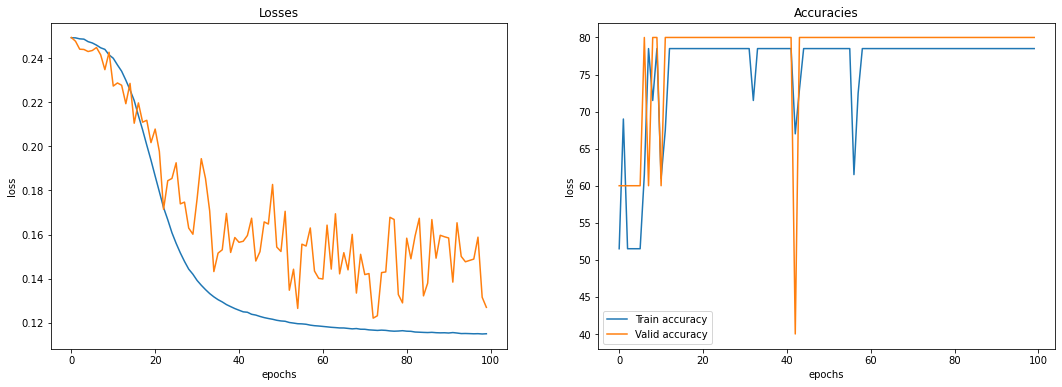

In [38]:
lr = 0.03
bs = 40
datasets, loaders = get_data(bs)
g=0.7
epochs=100

activation_collector=activationsCollector(g, epochs, len(loaders['train'].dataset))
Xorln = learner(XORnet3(), lr, 'adam')
model, opt, loss_fn = Xorln.get_model()


loggers = fit2(model, opt, loaders, epochs, activation_collector)
plotTraining(loggers, Xorln)

In [40]:
print(activation_collector.neurons.keys())

dict_keys(['0-0', '0-1', '1-0', '1-1', '2-0'])


In [42]:
print(activation_collector.neurons['1-0'][0])

0.4287649989128113


In [141]:

vis={}
def hook_fn(m, i, o):
    print('m class name:', m.__class__.__name__, ', i:', i.__class__.__name__, ', o:' , o.__class__.__name__)
    print(m, ':::', i,':::',  o)
    vis[m]=o
# nnSigmoidLayers = [layer for layer in model.layers if type(layer) == nn.Sigmoid]
nnSigmoidLayers = [model.sig1, model.sig2]
for layer in nnSigmoidLayers:
    layer.register_forward_hook(hook_fn)

In [142]:
model.activations = []

In [143]:
x_in = torch.tensor([[0.0, 1.0]])

In [144]:
pred = model(x_in)

m class name: Sigmoid , i: tuple , o: Tensor
Sigmoid() ::: (tensor([[12.2968,  2.6585]], grad_fn=<AddmmBackward>),) ::: tensor([[1.0000, 0.9345]], grad_fn=<SigmoidBackward>)
m class name: Sigmoid , i: tuple , o: Tensor
Sigmoid() ::: (tensor([[2.9484]], grad_fn=<AddmmBackward>),) ::: tensor([[0.9502]], grad_fn=<SigmoidBackward>)


In [145]:
model.activations

[[tensor([[0., 1.]]),
  tensor([[1.0000, 0.9345]], grad_fn=<SigmoidBackward>),
  tensor([[0.9502]], grad_fn=<SigmoidBackward>)]]

In [152]:
mylist = [model.activations[0][0].numpy(),
*model.activations[0][1].detach().numpy(),
*model.activations[0][2].detach().numpy()]
mylist
# https://stackoverflow.com/questions/53903373/convert-pytorch-tensor-to-python-list

[array([0., 1.], dtype=float32),
 array([0.99999547, 0.93453544], dtype=float32),
 array([0.9501885], dtype=float32)]

In [114]:
model.layers[2].weight

Parameter containing:
tensor([[-6.7561,  5.5437]], requires_grad=True)

In [116]:
vis

{Sigmoid(): tensor([[0.0036, 0.8639]], grad_fn=<SigmoidBackward>),
 Sigmoid(): tensor([[0.9288]], grad_fn=<SigmoidBackward>)}

In [117]:
pred

tensor([[0.9288]], grad_fn=<SigmoidBackward>)

In [119]:
model.layers.fc1.weight, model.layers.fc1.bias

(Parameter containing:
 tensor([[-6.5834, -8.2177],
         [-4.7596, -4.9996]], requires_grad=True),
 Parameter containing:
 tensor([-2.1961], requires_grad=True))

In [155]:
model.fc2.weight, model.fc2.bias

(Parameter containing:
 tensor([[-5.4566,  6.3949]], requires_grad=True),
 Parameter containing:
 tensor([2.4287], requires_grad=True))

In [156]:
type(model.fc1)

torch.nn.modules.linear.Linear

# optimizer

http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html   


In [ ]:
from torch.optim import Optimizer
class SGDWithTE(Optimizer):
    '''
    Implement backpropagation algorithm with a twist
    Using inter-neuron transfer entropy to change the weight update
    Wl:= Wl − η∆l(1 − tel)
    '''